# Goal of Aanalysis:

### 1. create a list to identify those users who never went above the monthly credit card limit (calendar month). The goal of this is to automatically increase their limit

### 2. oimplement an algorithm that as soon as a user goes above her monthly limit, it triggers an alert so that the user can be notiﬁed about that

### 3.  implement an unsupervised algorithm that returns all transactions that seem unusual and are worth being investigated further

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
info = pd.read_csv('cc_info.csv')
info.head()

,credit_card,city,state,zipcode,credit_card_limit
0,1280981422329509,Dallas,PA,18612,6000
1,9737219864179988,Houston,PA,15342,16000
2,4749889059323202,Auburn,MA,1501,14000
3,9591503562024072,Orlando,WV,26412,18000
4,2095640259001271,New York,NY,10001,20000


In [3]:
transaction = pd.read_csv('transactions.csv', parse_dates = ['date'])
transaction.head()

,credit_card,date,transaction_dollar_amount,Long,Lat
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719


I will first merge two dataset into one and do my analysis based on this

In [4]:
data = pd.merge(left=transaction, right=info, on='credit_card', how='left')
data.head()

,credit_card,date,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370,Houston,PA,15342,20000
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114,Houston,PA,15342,20000
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004,Houston,PA,15342,20000
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895,Houston,PA,15342,20000
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719,Houston,PA,15342,20000


In [5]:
info.shape, transaction.shape, data.shape

((984, 5), (294588, 5), (294588, 9))

In [6]:
# extract month, weekday, and hour information
data['month'] = data['date'].apply(lambda x: x.month)
data['day'] = data['date'].apply(lambda x: x.day)
data['weekday'] = data['date'].apply(lambda x: x.dayofweek)
data['hour'] = data['date'].apply(lambda x: x.hour)

# drop useless features
data = data.drop(labels='date', axis=1)

data.head()

,credit_card,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit,month,day,weekday,hour
0,1003715054175576,43.78,-80.174132,40.267370,Houston,PA,15342,20000,9,11,4,0
1,1003715054175576,103.15,-80.194240,40.180114,Houston,PA,15342,20000,10,24,5,22
2,1003715054175576,48.55,-80.211033,40.313004,Houston,PA,15342,20000,10,26,0,18
3,1003715054175576,136.18,-80.174138,40.290895,Houston,PA,15342,20000,10,22,3,19
4,1003715054175576,71.82,-80.238720,40.166719,Houston,PA,15342,20000,10,26,0,20


### Part 1: identify users who never went above the credit limit

In [7]:
def monthly_transaction(df):
    """ function to calculate montly total transactions """
    total_trans = df['transaction_dollar_amount'].sum()
    credit_limit = df['credit_card_limit'].values[0]
    
    return pd.Series([total_trans, credit_limit], index=['total_transaction', 'credit_limit'])

In [8]:
# find users who never exceed credit limit
grouped = data.groupby(['credit_card', 'month']).apply(monthly_transaction)
grouped = grouped.reset_index()

grouped['exceed'] = (grouped['total_transaction'] > grouped['credit_limit']).astype(int)
grouped_sum = grouped.groupby('credit_card')['exceed'].sum().reset_index()

lists = grouped_sum[grouped_sum['exceed'] == 0][['credit_card']]

print('Valid users:\t', len(lists))
lists.head()

Valid users:	 862


,credit_card
0,1003715054175576
1,1013870087888817
2,1023820165155391
3,1073931538936472
4,1077622576192810


We can see from the analysis, there are 862 people in total who never exceed their credit limit.

### Part 2: We assume here that at the beginning of the new month, user total money spent gets reset to zero (i.e. she pays the card fully at the end of each month). Build a function that for each day, returns a list of users who went above their credit card monthly limit on that day

In [9]:
def alert(data, month, day):
    """ function to return the list of credit cards that exceed the limit """
    data = data[(data['month'] == month) & (data['day'] <= day)]
    limit = data.groupby('credit_card')['credit_card_limit'].min().reset_index()
    transaction = data.groupby('credit_card')['transaction_dollar_amount'].sum().reset_index()
    
    merged = pd.merge(left=transaction, right=limit, on='credit_card', how='left')
    result = merged[merged['transaction_dollar_amount'] > merged['credit_card_limit']]
    
    return result

after we built the function, we try to see the data on August 20th:

In [10]:
alert(data, month=8, day=20)

,credit_card,transaction_dollar_amount,credit_card_limit
194,2850146878241916,4012.81,4000
319,3936887050542904,5352.07,4000
341,4118286032166087,3416.52,3000
383,4462290711836916,3119.53,2000
525,5723635641134781,2161.30,2000
698,7299183791723634,7074.49,7000
772,7850942767136368,5704.00,4000
834,8522875529951473,5860.89,5000
874,8972201384562696,5266.08,5000


### Part 3: an unsupervised algorithms

In [11]:
import warnings
warnings.filterwarnings('ignore')

# calculate the median for Longitude and Latitude
address = data.groupby('credit_card')['Long', 'Lat'].mean().reset_index()
address = address.rename(columns={'Long': 'Long_median', 'Lat': 'Lat_median'})
data = pd.merge(left=data, right=address, on='credit_card', how='left')
data.head()

,credit_card,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit,month,day,weekday,hour,Long_median,Lat_median
0,1003715054175576,43.78,-80.174132,40.267370,Houston,PA,15342,20000,9,11,4,0,-77.583829,39.610299
1,1003715054175576,103.15,-80.194240,40.180114,Houston,PA,15342,20000,10,24,5,22,-77.583829,39.610299
2,1003715054175576,48.55,-80.211033,40.313004,Houston,PA,15342,20000,10,26,0,18,-77.583829,39.610299
3,1003715054175576,136.18,-80.174138,40.290895,Houston,PA,15342,20000,10,22,3,19,-77.583829,39.610299
4,1003715054175576,71.82,-80.238720,40.166719,Houston,PA,15342,20000,10,26,0,20,-77.583829,39.610299


In [12]:
# calculate the distance
data['distance'] = np.sqrt((data['Long'] - data['Long_median'])**2 + (data['Lat'] - data['Lat_median'])**2)

In [13]:
# calculate user transaction median
median = data.groupby('credit_card')['transaction_dollar_amount'].median().reset_index()
median = median.rename(columns={'transaction_dollar_amount': 'transaction_median'})
data = pd.merge(left=data, right=median, on='credit_card', how='left')

In [14]:
# extract useful information
data['transaction_to_median'] = data['transaction_dollar_amount'] / data['transaction_median']
data['transaction_to_limit'] = data['transaction_dollar_amount'] / data['credit_card_limit']

data.head()

,credit_card,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit,month,day,weekday,hour,Long_median,Lat_median,distance,transaction_median,transaction_to_median,transaction_to_limit
0,1003715054175576,43.78,-80.174132,40.267370,Houston,PA,15342,20000,9,11,4,0,-77.583829,39.610299,2.672342,93.73,0.467086,0.002189
1,1003715054175576,103.15,-80.194240,40.180114,Houston,PA,15342,20000,10,24,5,22,-77.583829,39.610299,2.671878,93.73,1.100501,0.005158
2,1003715054175576,48.55,-80.211033,40.313004,Houston,PA,15342,20000,10,26,0,18,-77.583829,39.610299,2.719557,93.73,0.517977,0.002427
3,1003715054175576,136.18,-80.174138,40.290895,Houston,PA,15342,20000,10,22,3,19,-77.583829,39.610299,2.678229,93.73,1.452897,0.006809
4,1003715054175576,71.82,-80.238720,40.166719,Houston,PA,15342,20000,10,26,0,20,-77.583829,39.610299,2.712572,93.73,0.766243,0.003591


In [15]:
# drop useless features
labels = ['transaction_dollar_amount', 'Long', 'Lat', 'city', 'state', 'zipcode', 'credit_card_limit', 
          'month', 'day', 'Long_median', 'Lat_median', 'transaction_median']
data = data.drop(labels=labels, axis=1)
data.head()

,credit_card,weekday,hour,distance,transaction_to_median,transaction_to_limit
0,1003715054175576,4,0,2.672342,0.467086,0.002189
1,1003715054175576,5,22,2.671878,1.100501,0.005158
2,1003715054175576,0,18,2.719557,0.517977,0.002427
3,1003715054175576,3,19,2.678229,1.452897,0.006809
4,1003715054175576,0,20,2.712572,0.766243,0.003591


In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest

# normalize the data
x = data[['weekday', 'hour', 'distance', 'transaction_to_median', 'transaction_to_limit']]
# x = data[['distance', 'transaction_to_median', 'transaction_to_limit']]
scaler = StandardScaler()
norm_x = scaler.fit_transform(x)

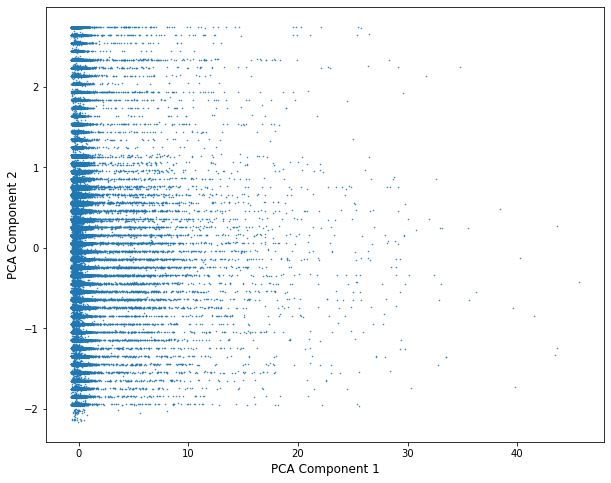

In [17]:
# apply PCA
pca = PCA(n_components=2, random_state=42)
pca_x = pca.fit_transform(norm_x)

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(pca_x[:, 0], pca_x[:, 1], '.', markersize=1)
ax.set_xlabel('PCA Component 1', fontsize=12)
ax.set_ylabel('PCA Component 2', fontsize=12)
plt.show()

In [18]:
# build isolation forest model
forest = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.1, 
                         max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42)
forest = forest.fit(norm_x)
score = forest.decision_function(norm_x)
label = forest.predict(norm_x)

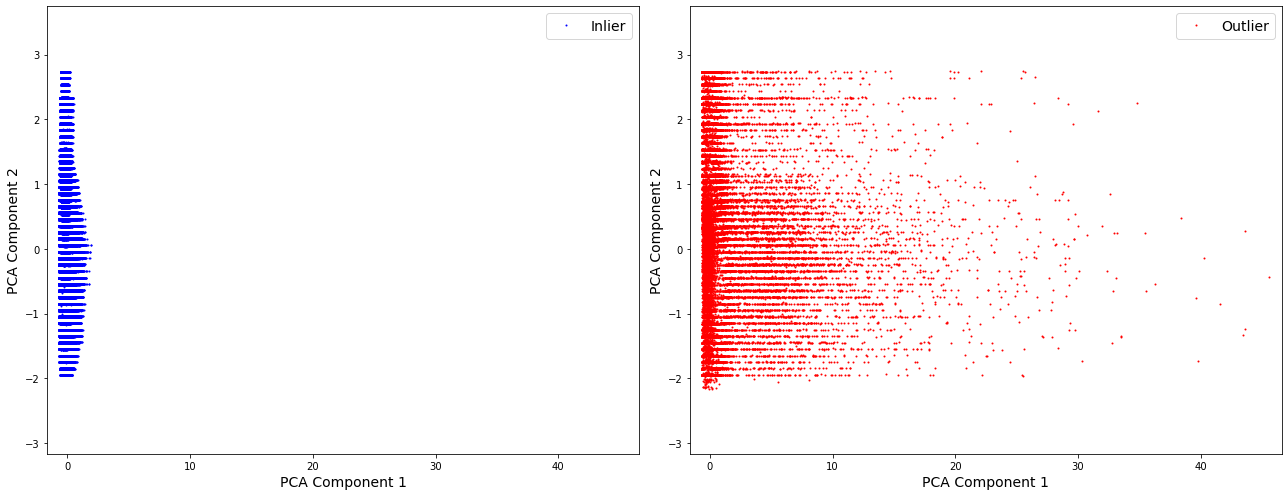

In [19]:
# visualization
inlier = pca_x[label == 1]
outlier = pca_x[label == -1]
xmin = pca_x[:, 0].min() - 1
xmax = pca_x[:, 0].max() + 1
ymin = pca_x[:, 1].min() - 1
ymax = pca_x[:, 1].max() + 1

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
ax[0].plot(inlier[:, 0], inlier[:, 1], 'b.', markersize=2, label='Inlier')
ax[0].set_xlabel('PCA Component 1', fontsize=14)
ax[0].set_ylabel('PCA Component 2', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].set_xlim([xmin, xmax])
ax[0].set_ylim([ymin, ymax])
ax[1].plot(outlier[:, 0], outlier[:, 1], 'r.', markersize=2, label='Outlier')
ax[1].set_xlabel('PCA Component 1', fontsize=14)
ax[1].set_ylabel('PCA Component 2', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].set_xlim([xmin, xmax])
ax[1].set_ylim([ymin, ymax])
plt.tight_layout()
plt.show()

There are different methods for unsupervised anomaly detection, such as Isolation Forest, One-Class SVM, DBSCAN and so on.

Here, for simplicity, only DBSCAN method with default parameters is implemented.